## Data analysis for crack dataset

In [1]:
import xml.etree.ElementTree as ElementTree
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

In [2]:
# define the label-meta-data file path
# one file for background and one for 5 defects

xml_path = '/Users/elenath/ALEX/EPFL/Courses/Machine Learning/Project/p2_data/data/classification_dataset_balanced/metadata'
xml_files = ['background.xml', 'defects.xml']

train_path = '/Users/elenath/ALEX/EPFL/Courses/Machine Learning/Project/p2_data/data/classification_dataset_balanced/train'
val_path = '/Users/elenath/ALEX/EPFL/Courses/Machine Learning/Project/p2_data/data/classification_dataset_balanced/val'
test_path = '/Users/elenath/ALEX/EPFL/Courses/Machine Learning/Project/p2_data/data/classification_dataset_balanced/test'


In [8]:
# parse the file and get labels
"""
example of defect xml element:
  <Defect name="image_0001574_crop_0000004.png">
      <Background>1</Background>
      <Crack>0</Crack>
      <Spallation>0</Spallation>
      <Efflorescence>0</Efflorescence>
      <ExposedBars>0</ExposedBars>
      <CorrosionStain>0</CorrosionStain>
  </Defect>
"""

# get train files
train_files = []
train_files += [f for f in os.listdir(train_path+'/background') if f != '.DS_Store']
train_files += [f for f in os.listdir(train_path+'/defects') if f != '.DS_Store']
train_files = set(train_files)  # accelarate the query speed
# get val files
val_files = []
val_files += [f for f in os.listdir(val_path+'/background') if f != '.DS_Store']
val_files += [f for f in os.listdir(val_path+'/defects') if f != '.DS_Store']
val_files = set(val_files)  # accelarate the query speed
# get test file
test_files = []
test_files += [f for f in os.listdir(test_path+'/background') if f != '.DS_Store']
test_files += [f for f in os.listdir(test_path+'/defects') if f != '.DS_Store']
test_files = set(test_files)  # accelarate the query speed

# label count corresponding to:
# [Background, Crack, Spallation, Efflorescence, ExposedBars, CorrosionStain]
overall_label_count = [0, 0, 0, 0, 0, 0]
train_label_count = [0, 0, 0, 0, 0, 0]
val_label_count = [0, 0, 0, 0, 0, 0]
test_label_count = [0, 0, 0, 0, 0, 0]

# get the statistics
no_copy_file_count = 0
for xml_file_path in [xml_path+'/'+f for f in xml_files]:
    tree = ElementTree.parse(xml_file_path)  # parse the xml file
    root = tree.getroot()
    for elem in root:
        crop_file_name = list(elem.attrib.values())[0]  # img file name
        if 'copy' in crop_file_name:
            continue
        no_copy_file_count += 1
        if crop_file_name in train_files:
            for i in range(6):  # 6 is the class num
                overall_label_count[i] += int(elem[i].text)
                train_label_count[i] += int(elem[i].text)
        if crop_file_name in val_files:
            for i in range(6):  # 6 is the class num
                overall_label_count[i] += int(elem[i].text)
                val_label_count[i] += int(elem[i].text)
        if crop_file_name in test_files:
            for i in range(6):  # 6 is the class num
                overall_label_count[i] += int(elem[i].text)
                test_label_count[i] += int(elem[i].text)

In [7]:
train_label_count

[2185, 2208, 1608, 543, 1215, 1263]

In [9]:
no_copy_file_count

7736

In [16]:
balance_weight = [(no_copy_file_count-l)/l for l in train_label_count]
[i/balance_weight[0] for i in balance_weight]
# balance_weight

[1.0,
 0.9854830961388338,
 1.5000748374861417,
 5.214233129729914,
 2.1126041872854255,
 2.0173556568167372]

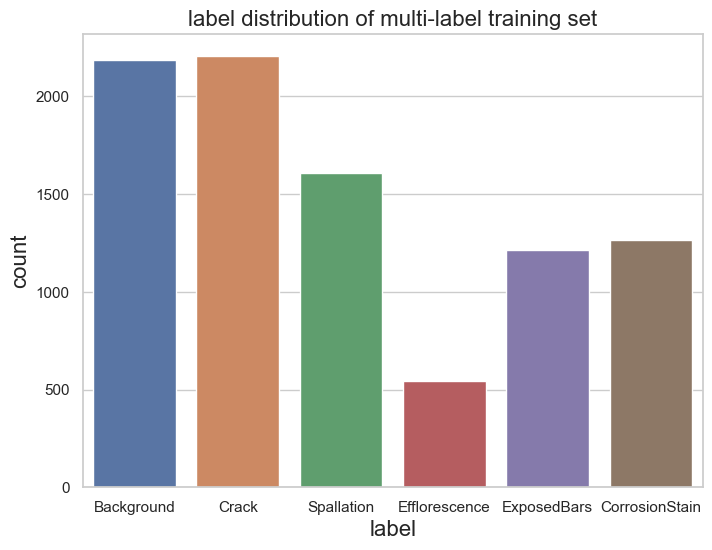

In [51]:
# visualzie the label distribution

sns.set_theme(style="whitegrid")
plt.figure(figsize=(8,6), dpi=100)
plt.xticks(rotation=0)
plt.xlabel('label', size=16)
plt.ylabel('count', size=16)
plt.title('label distribution of multi-label training set', size=16)
ax = sns.barplot(
    x=['Background', 'Crack', 'Spallation', 'Efflorescence', 'ExposedBars', 'CorrosionStain'],
    y = train_label_count
    )



## Image-related properties analysis

In [3]:
import cv2

In [4]:
def get_file_paths(folder_path):
    """
    get the file path list from a folder
    """
    return [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f != '.DS_Store']

In [16]:
# get the path of train, val, test files
sub_folders = ['background', 'defects']
train_file_paths = get_file_paths(os.path.join(train_path, 'background')) + get_file_paths(os.path.join(train_path, 'defects'))
val_file_paths = get_file_paths(os.path.join(val_path, 'background')) + get_file_paths(os.path.join(val_path, 'defects'))
test_file_paths = get_file_paths(os.path.join(test_path, 'background')) + get_file_paths(os.path.join(test_path, 'defects'))
# combine and get all file paths

img_lengths = []
img_widths = []
# prepare for count the mean and std of images
R_channel_mean = 0 
B_channel_mean = 0 
G_channel_mean = 0 
R_channel_mean2 = 0
B_channel_mean2 = 0
G_channel_mean2 = 0

# analysis the statistics
img_num = len(train_file_paths)
for fp in tqdm(train_file_paths):
    img = cv2.imread(fp)/255
    img_lengths.append(img.shape[0])  # get the lengths of images
    img_widths.append(img.shape[1])  # get the widths of images
    # the std is computed as std = mean(mean_img*2)
    r_mean = img[:,:,0].mean()
    b_mean = img[:,:,1].mean()
    g_mean = img[:,:,2].mean()
    R_channel_mean += r_mean
    B_channel_mean += b_mean
    G_channel_mean += g_mean
    R_channel_mean2 += r_mean**2
    B_channel_mean2 += b_mean**2
    G_channel_mean2 += g_mean**2

# get the mean and std values
r_mean_all = R_channel_mean / img_num
g_mean_all = G_channel_mean / img_num
b_mean_all = B_channel_mean / img_num
r_mean2_all = R_channel_mean2 / img_num
g_mean2_all = G_channel_mean2 / img_num
b_mean2_all = B_channel_mean2 / img_num
rgb_mean_values = [r_mean_all, g_mean_all, b_mean_all]
rgb_std_values = [r_mean2_all - r_mean_all**2, g_mean2_all - g_mean_all**2, b_mean2_all - b_mean_all**2]

100%|██████████| 9209/9209 [04:46<00:00, 32.15it/s]


In [20]:
print(rgb_mean_values)

[0.49890367846548267, 0.5593151255125131, 0.5353131951536053]


In [21]:
rgb_std_values

[0.021385479802489143, 0.018600295240998266, 0.019055388840825138]

Text(0.5, 0.98, 'image resolution distribution of CODEBRIM data')

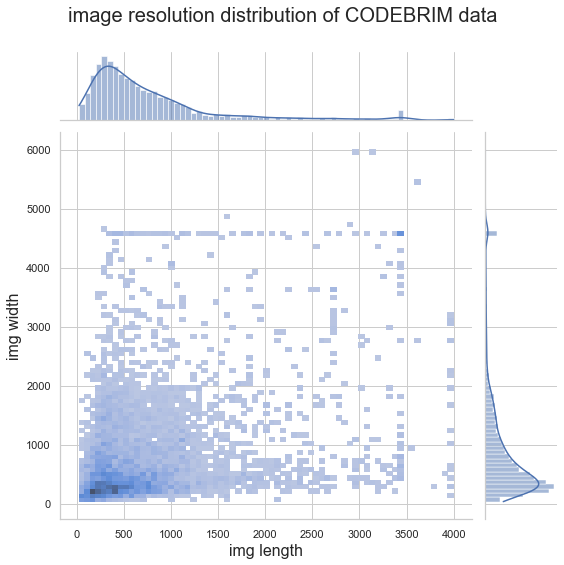

In [58]:
# plot the resolution distribution of pictures

g = sns.JointGrid(x=img_lengths, y=img_widths, height=8)
g.plot_joint(sns.histplot)
g.plot_marginals(sns.histplot, kde=True)
g.set_axis_labels('img length', 'img width', fontsize=16)
# g.set_title('a')
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle('image resolution distribution of CODEBRIM data', fontsize=20)
# g.xticks(rotation=0)
# g.title('image length and width joint distribution of CODEBRIM data')
# g.xlabel('length', size=16)
# g.ylabel('width', size=16)